In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import statsmodels.api as sm
import plotly.express as px
from utilities import utils
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
# Prophet model for time series forecast
from prophet import Prophet# Visualization
from prophet.plot import add_changepoints_to_plot
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
# Multi-processing
from multiprocessing import Pool, cpu_count
from time import time
# Process bar
from tqdm import tqdm

c:\Users\Katlego\Anaconda3\envs\WFP\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('rainfall_by_country.csv')

In [3]:
def create_month_decades(df,decade_2 = int(11),decade_3 = int(21)):
    try:
        if df['decade'] == 2:
            return df['date'] + pd.tseries.offsets.DateOffset(day = decade_2)
        elif df['decade'] == 3:
            return df['date'] + pd.tseries.offsets.DateOffset(day = decade_3)
        else:
            return df['date']
    except Exception as e:
            print(f"Exception on creating decades date: {e}") 

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265620 entries, 0 to 265619
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   AdminCode      265620 non-null  int64  
 1   mean_rainfall  265620 non-null  float64
 2   year           265620 non-null  int64  
 3   month          265620 non-null  int64  
 4   decade         265620 non-null  int64  
dtypes: float64(1), int64(4)
memory usage: 10.1 MB


In [5]:
utils.print_num_rows_cols(df,'Rainfall')

Rainfall data has 5 columns and 265620 rows.


In [6]:
utils.check_null_values(df)

There are 0 columns that have missing values


,Missing Values,% of Total Values


In [7]:
# Checking the number of unique fields
print("Below are the number of unique variables for each column:")
for col in df.columns:
    print(f"{col}: {df[col].nunique()}")

Below are the number of unique variables for each column:
AdminCode: 245
mean_rainfall: 80518
year: 30
month: 12
decade: 3


Text(0, 0.5, 'Data type')

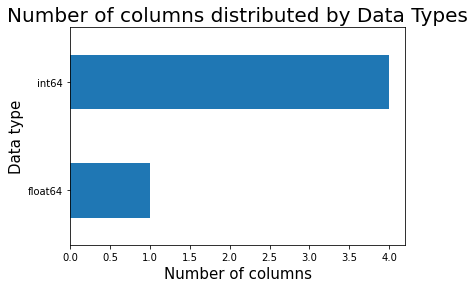

In [8]:
# Number of each type of column
df.dtypes.value_counts().sort_values().plot(kind='barh')
plt.title('Number of columns distributed by Data Types',fontsize=20)
plt.xlabel('Number of columns',fontsize=15)
plt.ylabel('Data type',fontsize=15)

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
AdminCode,265620.0,3509.388344,18051.579411,1.0,75.000,162.0,243.0000,147299.0
mean_rainfall,265620.0,32.397389,40.552156,-1.0,5.188,18.0,44.6115,668.0
year,265620.0,2004.496725,8.653691,1990.0,1997.000,2004.0,2012.0000,2019.0
month,265620.0,6.499548,3.452277,1.0,3.000,6.0,10.0000,12.0
decade,265620.0,1.999910,0.816517,1.0,1.000,2.0,3.0000,3.0


- Mean Rainfall has some -1.0 values. One can either drop the AdminCode-time series or replace those value with NaN and predict them accordingly. 

### Preprocess to Get Decade Datetime columns

In [10]:
df['date'] = df['year'].astype(str) + '-' + df['month'].astype(str).str.zfill(2) + '-' + df['decade'].astype(str).str.zfill(2)
df['date'] = pd.to_datetime(df['date'])
df['date_decade'] = df.apply(lambda row: create_month_decades(row), axis=1)
df = utils.generate_date_features(df)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265620 entries, 0 to 265619
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   AdminCode         265620 non-null  int64         
 1   mean_rainfall     265620 non-null  float64       
 2   year              265620 non-null  int64         
 3   month             265620 non-null  int64         
 4   decade            265620 non-null  int64         
 5   date              265620 non-null  datetime64[ns]
 6   date_decade       265620 non-null  datetime64[ns]
 7   month_name        265620 non-null  object        
 8   isstartofmonth    265620 non-null  float64       
 9   day_name          265620 non-null  object        
 10  dayofweek         265620 non-null  int64         
 11  isweekend         265620 non-null  float64       
 12  weekofmonth       265620 non-null  int32         
 13  quarter           265620 non-null  int64         
 14  isst

In [12]:
df['AdminCode'] = df['AdminCode'].astype(str)

# Exploratory Data Analysis

In [13]:
## Imputed Values Analysis

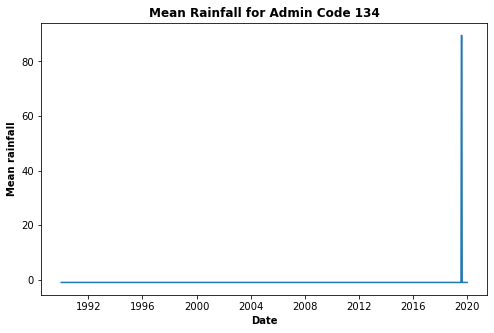

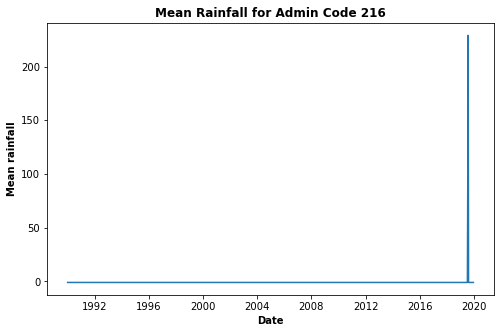

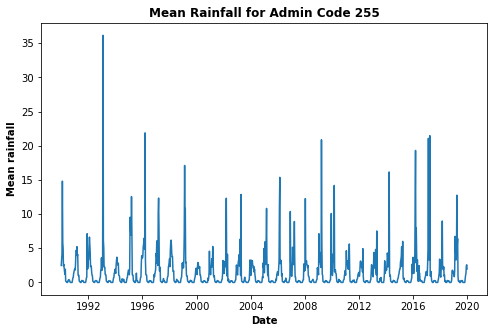

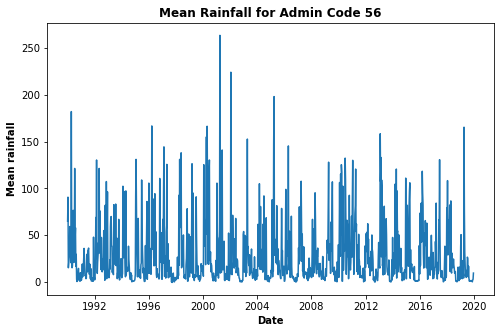

In [14]:
for admin in df[df['mean_rainfall'] < 0]['AdminCode'].unique():
    plt.figure(figsize=(8, 5))
    plt.plot(df[df['AdminCode'] == admin]['date_decade'], df[df['AdminCode'] ==admin]['mean_rainfall'])
    plt.title(f'Mean Rainfall for Admin Code {admin}',fontweight='bold')
    plt.xlabel('Date',fontweight='bold')
    plt.ylabel('Mean rainfall',fontweight='bold')
    plt.show()

- There are 4 regions (Admin Codes) with -1.0 as an imputated values.
- Admin codes 216 and 134 have not typical rainfall patterns/signals whilst Admin codes 255 and 56 have typical rainfall patterns
- These will likely be dropped.

## Sample Time Series Analysis

In [15]:
df_273 = df[df['AdminCode'] == '273']
df_278 = df[df['AdminCode'] == '278']
df_90 = df[df['AdminCode'] == '90']
df_42 = df[df['AdminCode'] == '42']

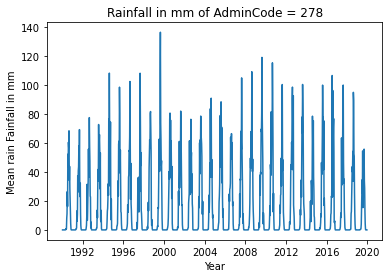

In [16]:
plt.plot(df_278['date_decade'], df_278['mean_rainfall'])
plt.xlabel('Year')
plt.ylabel('Mean rain Fainfall in mm')
plt.title('Rainfall in mm of AdminCode = 278')
plt.show()

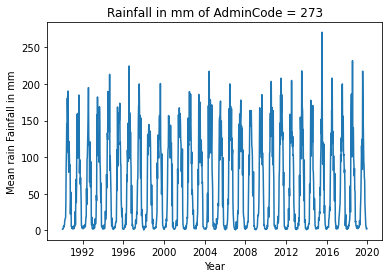

In [17]:
plt.plot(df_273['date_decade'], df_273['mean_rainfall'])
plt.xlabel('Year')
plt.ylabel('Mean rain Fainfall in mm')
plt.title('Rainfall in mm of AdminCode = 273')
plt.show()

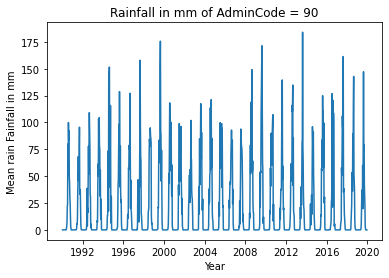

In [18]:
plt.plot(df_90['date_decade'], df_90['mean_rainfall'])
plt.xlabel('Year')
plt.ylabel('Mean rain Fainfall in mm')
plt.title('Rainfall in mm of AdminCode = 90')
plt.show()

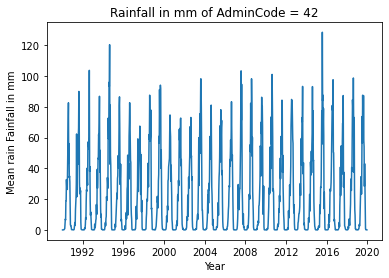

In [19]:
plt.plot(df_42['date_decade'], df_42['mean_rainfall'])
plt.xlabel('Year')
plt.ylabel('Mean rain Fainfall in mm')
plt.title('Rainfall in mm of AdminCode = 42')
plt.show()

- There are dry periods in years and significant wet season. The data seems to have some seasonality. Down below some monthly analysis for the subsets will be done.

## Mean rainfall Aanalysis for Different Periods

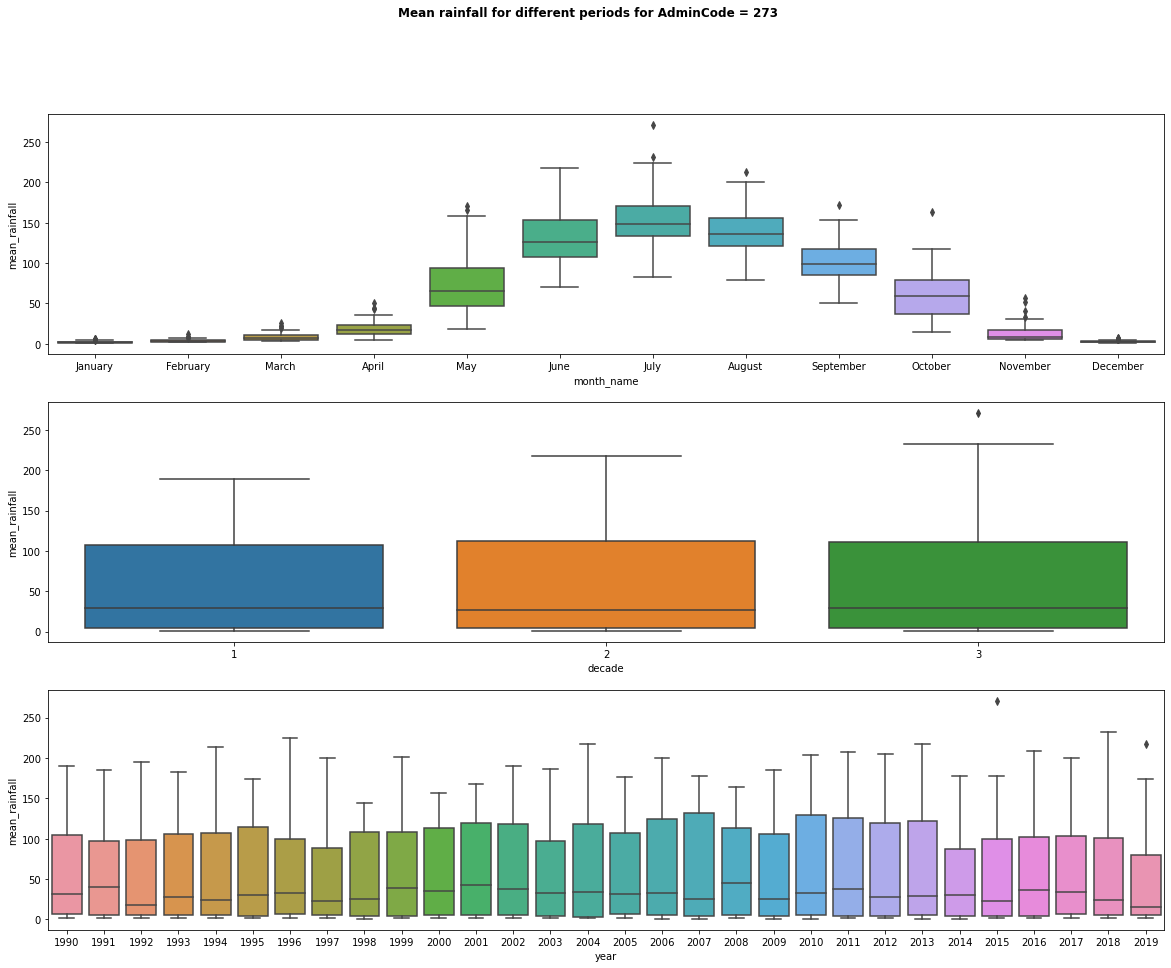

In [21]:
fig = plt.figure(figsize=(20, 15))
plt.suptitle('Mean rainfall for different periods for AdminCode = 273',fontweight='bold')
ax1 = fig.add_subplot(311)
sns.boxplot(data=df_273, x='month_name', y='mean_rainfall', ax=ax1)
ax2 = fig.add_subplot(312)
sns.boxplot(data=df_273, x='decade', y='mean_rainfall', ax=ax2)
ax3 = fig.add_subplot(313)
sns.boxplot(data=df_273, x='year', y='mean_rainfall', ax=ax3)
plt.show()

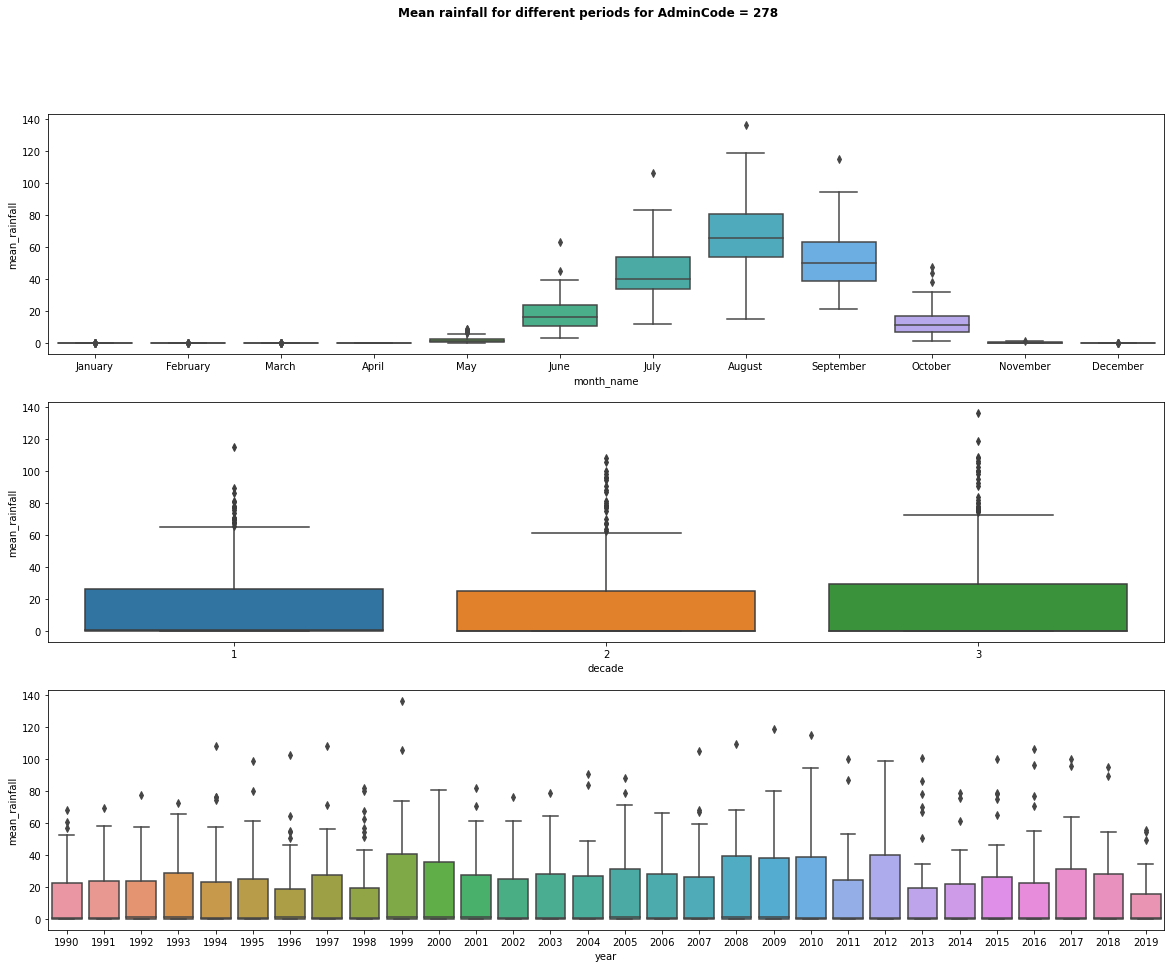

In [22]:
fig = plt.figure(figsize=(20, 15))
plt.suptitle('Mean rainfall for different periods for AdminCode = 278',fontweight='bold')
ax1 = fig.add_subplot(311)
sns.boxplot(data=df_278, x='month_name', y='mean_rainfall', ax=ax1)
ax2 = fig.add_subplot(312)
sns.boxplot(data=df_278, x='decade', y='mean_rainfall', ax=ax2)
ax3 = fig.add_subplot(313)
sns.boxplot(data=df_278, x='year', y='mean_rainfall', ax=ax3)
plt.show()

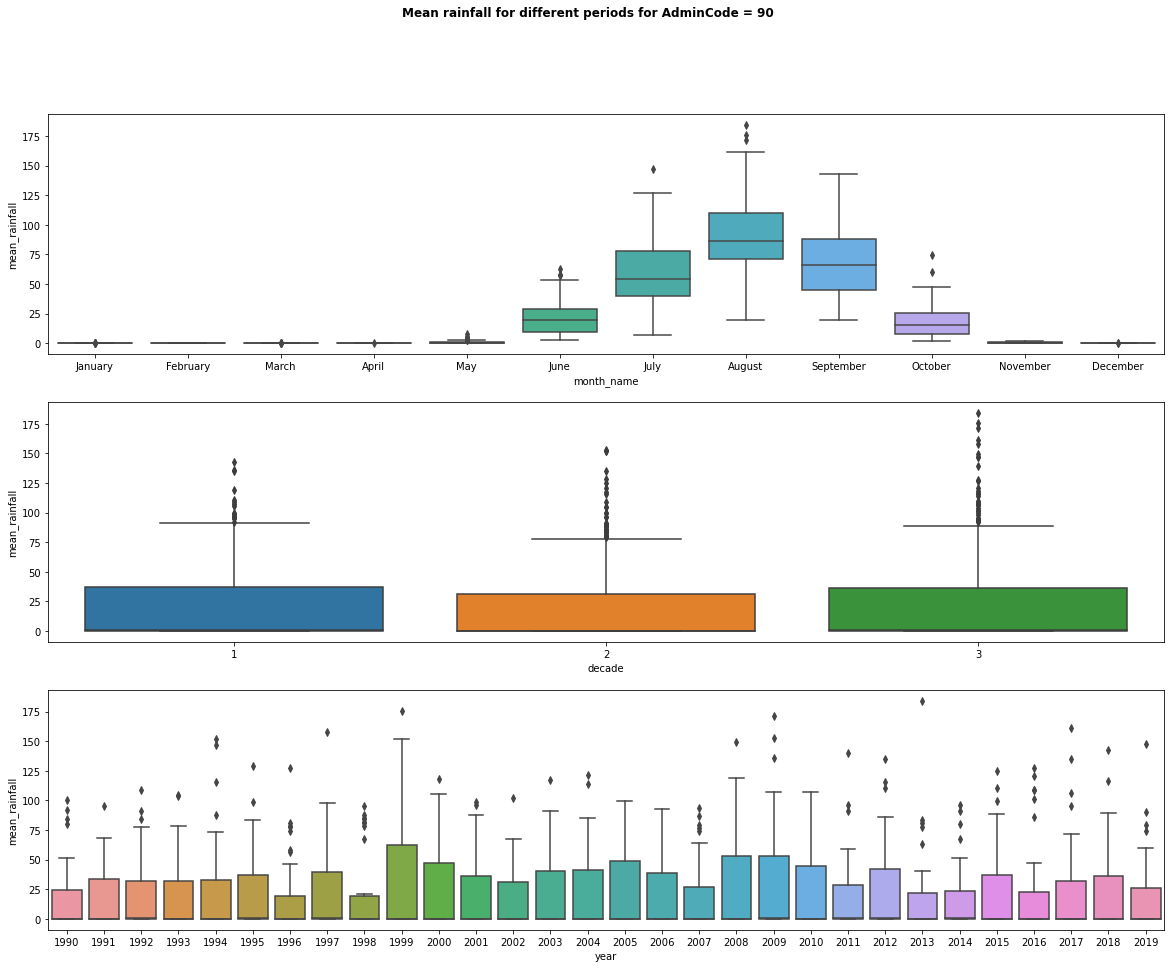

In [23]:
fig = plt.figure(figsize=(20, 15))
plt.suptitle('Mean rainfall for different periods for AdminCode = 90',fontweight='bold')
ax1 = fig.add_subplot(311)
sns.boxplot(data=df_90, x='month_name', y='mean_rainfall', ax=ax1)
ax2 = fig.add_subplot(312)
sns.boxplot(data=df_90, x='decade', y='mean_rainfall', ax=ax2)
ax3 = fig.add_subplot(313)
sns.boxplot(data=df_90, x='year', y='mean_rainfall', ax=ax3)
plt.show()

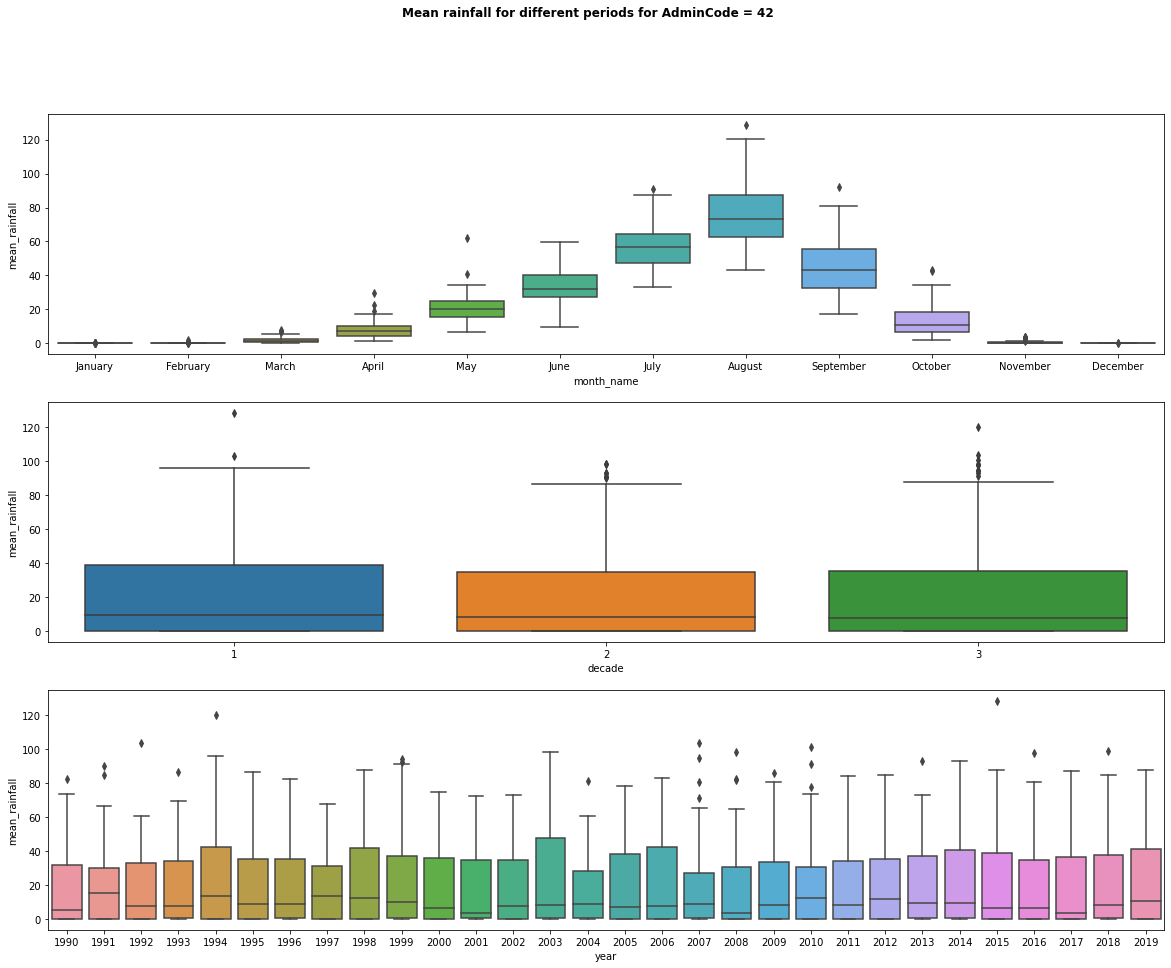

In [24]:
fig = plt.figure(figsize=(20, 15))
plt.suptitle('Mean rainfall for different periods for AdminCode = 42',fontweight='bold')
ax1 = fig.add_subplot(311)
sns.boxplot(data=df_42, x='month_name', y='mean_rainfall', ax=ax1)
ax2 = fig.add_subplot(312)
sns.boxplot(data=df_42, x='decade', y='mean_rainfall', ax=ax2)
ax3 = fig.add_subplot(313)
sns.boxplot(data=df_42, x='year', y='mean_rainfall', ax=ax3)
plt.show()

- There is no significant variation across each decade.
- The wet season can be between June -October or July - October depending on the region

<AxesSubplot:xlabel='quarter', ylabel='mean_rainfall'>

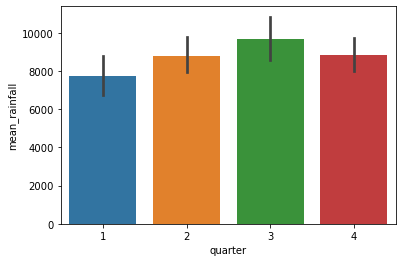

In [25]:
monthAggregated = pd.DataFrame(df.groupby(["AdminCode","quarter"])["mean_rainfall"].sum()).reset_index().sort_values('mean_rainfall')
sns.barplot(data=monthAggregated,x="quarter",y="mean_rainfall")
# ax3.set(xlabel='Quarter', ylabel='Total Sales received')
# ax3.set_title("Total Sales received By Quarter",fontsize=15)

## Stationarity Checks

In [26]:
utils.adf_test(df_278['mean_rainfall'])

Results of Dickey-Fuller Test:
Test Statistic                -1.610845e+01
p-value                        5.043147e-29
#Lags Used                     2.200000e+01
Number of Observations Used    1.055000e+03
Critical Value (1%)           -3.436564e+00
Critical Value (5%)           -2.864283e+00
Critical Value (10%)          -2.568231e+00
dtype: float64


In [27]:
utils.kpss_test(df_278['mean_rainfall'])

Results of KPSS Test:
Test Statistic            0.03425
p-value                   0.10000
Lags Used                18.00000
Critical Value (10%)      0.34700
Critical Value (5%)       0.46300
Critical Value (2.5%)     0.57400
Critical Value (1%)       0.73900
dtype: float64


c:\Users\Katlego\Anaconda3\envs\WFP\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [28]:
utils.adf_test(df_273['mean_rainfall'])

Results of Dickey-Fuller Test:
Test Statistic                -1.709253e+01
p-value                        7.573294e-30
#Lags Used                     2.200000e+01
Number of Observations Used    1.055000e+03
Critical Value (1%)           -3.436564e+00
Critical Value (5%)           -2.864283e+00
Critical Value (10%)          -2.568231e+00
dtype: float64


In [29]:
utils.kpss_test(df_273['mean_rainfall'])

Results of KPSS Test:
Test Statistic            0.011432
p-value                   0.100000
Lags Used                18.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


c:\Users\Katlego\Anaconda3\envs\WFP\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [30]:
utils.adf_test(df_90['mean_rainfall'])

Results of Dickey-Fuller Test:
Test Statistic                -1.553880e+01
p-value                        2.172707e-28
#Lags Used                     2.200000e+01
Number of Observations Used    1.057000e+03
Critical Value (1%)           -3.436552e+00
Critical Value (5%)           -2.864278e+00
Critical Value (10%)          -2.568228e+00
dtype: float64


In [31]:
utils.kpss_test(df_90['mean_rainfall'])

Results of KPSS Test:
Test Statistic            0.022414
p-value                   0.100000
Lags Used                17.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


c:\Users\Katlego\Anaconda3\envs\WFP\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [32]:
utils.adf_test(df_42['mean_rainfall'])

Results of Dickey-Fuller Test:
Test Statistic                -1.647380e+01
p-value                        2.270192e-29
#Lags Used                     2.200000e+01
Number of Observations Used    1.057000e+03
Critical Value (1%)           -3.436552e+00
Critical Value (5%)           -2.864278e+00
Critical Value (10%)          -2.568228e+00
dtype: float64


In [33]:
utils.kpss_test(df_42['mean_rainfall'])

Results of KPSS Test:
Test Statistic            0.026877
p-value                   0.100000
Lags Used                18.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


c:\Users\Katlego\Anaconda3\envs\WFP\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


# Modelling

In [34]:
df_model = df[['date_decade','AdminCode','mean_rainfall']]

In [35]:
df_model = df_model[~df_model['AdminCode'].isin(['134', '216'])]

In [36]:
# Group the data by AdminCode
groups_by_admin_code = df_model.groupby('AdminCode')# Check the groups in the dataframe
admin_code_list = df_model['AdminCode'].unique()

In [37]:
def train_and_forecast(group):  # Initiate the model
  m = Prophet(growth='linear',
                  yearly_seasonality=False,
                  weekly_seasonality=False,
                  daily_seasonality=False,
                  seasonality_mode='multiplicative',
                  seasonality_prior_scale=10,
                  changepoint_prior_scale=.05
                 ).add_seasonality(name='yearly',
                                    period=365.25,
                                    fourier_order=4,
                                    prior_scale=10,
                                    mode='additive')
  
  # Fit the model
  m.fit(group)  # Make predictions
  future = m.make_future_dataframe(periods=31, freq='D')

  forecast = m.predict(future)[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
  forecast['AdminCode'] = group['AdminCode'].iloc[0]
  cutoffs = list(pd.date_range(start='2001-01-01', end='2019-12-31', freq='MS'))
  df_cv = cross_validation(m, initial='3652 days', period='365 days', horizon = '31 days', parallel='processes')
  df_p = performance_metrics(df_cv)
    
  rmse = df_p['rmse'].mean()
  print(f'rmse:{rmse}')
  # Return the forecasted results
  return forecast[['ds', 'AdminCode', 'yhat', 'yhat_upper', 'yhat_lower']]

In [38]:
cutoffs = list(pd.date_range(start='2001-01-01', end='2019-12-31', freq='MS', closed=None))

C:\Users\Katlego\AppData\Local\Temp\ipykernel_15280\213932624.py:1: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  cutoffs = list(pd.date_range(start='2001-01-01', end='2019-12-31', freq='MS', closed=None))


In [39]:
admin_code_list = df_model['AdminCode'].unique()
df_model.rename(columns={'date_decade':'ds','mean_rainfall':'y'},inplace=True)
df = df_model

### Model for 278

12:08:02 - cmdstanpy - INFO - Chain [1] start processing
12:08:03 - cmdstanpy - INFO - Chain [1] done processing


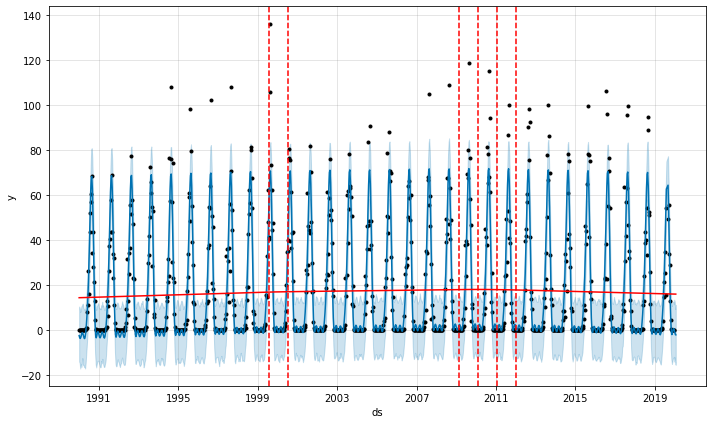

In [40]:
utils.individual_train_and_forecast(df,'278')

### Model for 273

12:08:04 - cmdstanpy - INFO - Chain [1] start processing
12:08:05 - cmdstanpy - INFO - Chain [1] done processing


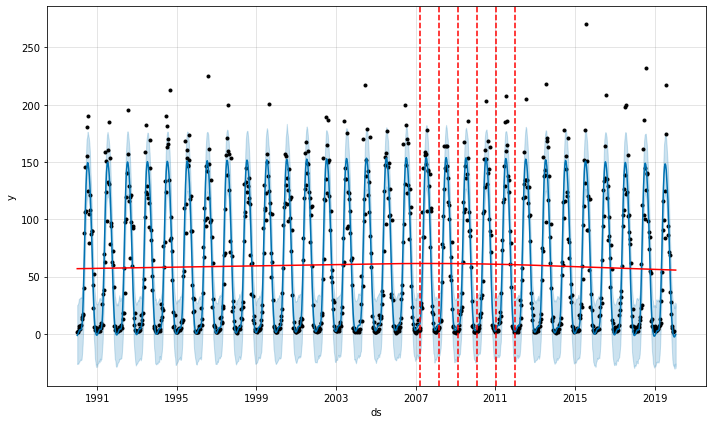

In [41]:
utils.individual_train_and_forecast(df,'273')

### Model for 90

12:08:06 - cmdstanpy - INFO - Chain [1] start processing
12:08:06 - cmdstanpy - INFO - Chain [1] done processing


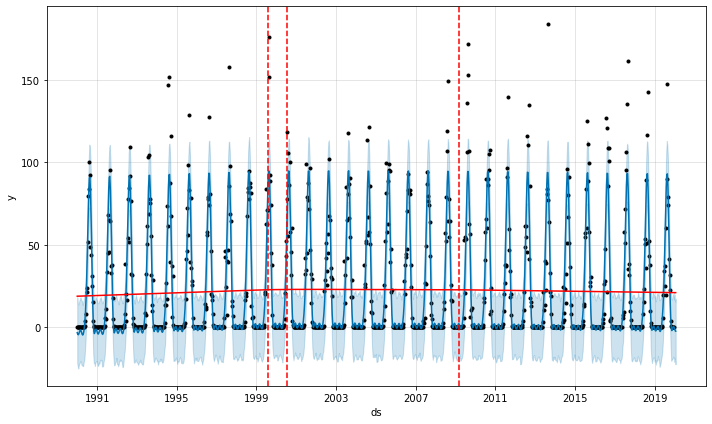

In [42]:
utils.individual_train_and_forecast(df,'90')

### Model for 42

12:08:08 - cmdstanpy - INFO - Chain [1] start processing
12:08:08 - cmdstanpy - INFO - Chain [1] done processing


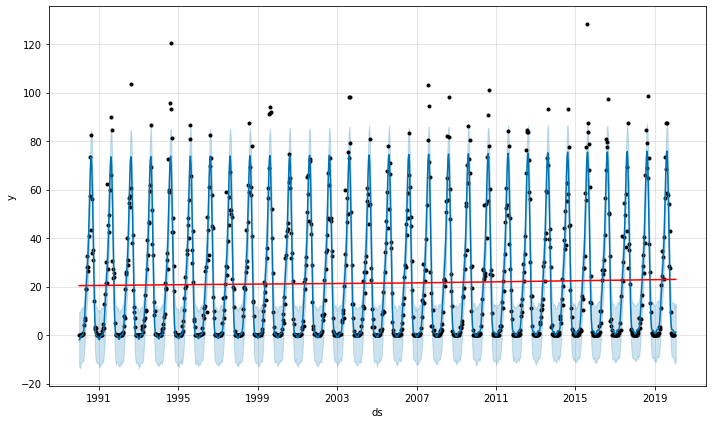

In [43]:
utils.individual_train_and_forecast(df,'42')

In [44]:
# Start time
start_time = time()# Create an empty dataframe
for_loop_forecast = pd.DataFrame()# Loop through each ticker
for admin_code in admin_code_list:
  # Get the data for the ticker
  group = groups_by_admin_code.get_group(admin_code)  
  # Make forecast
  forecast = train_and_forecast(group)
  # Add the forecast results to the dataframe
  
  for_loop_forecast = pd.concat((for_loop_forecast, forecast))
  
print('The time used for the for-loop forecast is ', time()-start_time)# Take a look at the data
for_loop_forecast.head()

12:08:09 - cmdstanpy - INFO - Chain [1] start processing
12:08:09 - cmdstanpy - INFO - Chain [1] done processing


rmse:2.8577852127152092


12:08:21 - cmdstanpy - INFO - Chain [1] start processing
12:08:21 - cmdstanpy - INFO - Chain [1] done processing


rmse:25.513129900596724


12:08:32 - cmdstanpy - INFO - Chain [1] start processing
12:08:32 - cmdstanpy - INFO - Chain [1] done processing


rmse:54.25580898125752


12:08:44 - cmdstanpy - INFO - Chain [1] start processing
12:08:45 - cmdstanpy - INFO - Chain [1] done processing


rmse:43.52606007234765


12:08:58 - cmdstanpy - INFO - Chain [1] start processing
12:08:58 - cmdstanpy - INFO - Chain [1] done processing


rmse:2.446302353676283


12:09:11 - cmdstanpy - INFO - Chain [1] start processing
12:09:11 - cmdstanpy - INFO - Chain [1] done processing


rmse:11.52871303428448


12:09:23 - cmdstanpy - INFO - Chain [1] start processing
12:09:23 - cmdstanpy - INFO - Chain [1] done processing


rmse:8.353434650451327


12:09:37 - cmdstanpy - INFO - Chain [1] start processing
12:09:37 - cmdstanpy - INFO - Chain [1] done processing


rmse:16.502424191807354


12:09:49 - cmdstanpy - INFO - Chain [1] start processing
12:09:49 - cmdstanpy - INFO - Chain [1] done processing


rmse:21.12131562683636


12:10:03 - cmdstanpy - INFO - Chain [1] start processing
12:10:03 - cmdstanpy - INFO - Chain [1] done processing


rmse:23.644606182104763


12:10:14 - cmdstanpy - INFO - Chain [1] start processing
12:10:14 - cmdstanpy - INFO - Chain [1] done processing


rmse:30.072161355367616


12:10:25 - cmdstanpy - INFO - Chain [1] start processing
12:10:25 - cmdstanpy - INFO - Chain [1] done processing


rmse:33.17166220273201


12:10:36 - cmdstanpy - INFO - Chain [1] start processing
12:10:36 - cmdstanpy - INFO - Chain [1] done processing


rmse:23.73704975438424


12:10:50 - cmdstanpy - INFO - Chain [1] start processing
12:10:50 - cmdstanpy - INFO - Chain [1] done processing


rmse:8.924940295945257


12:11:04 - cmdstanpy - INFO - Chain [1] start processing
12:11:04 - cmdstanpy - INFO - Chain [1] done processing


rmse:17.21321477533438


12:11:16 - cmdstanpy - INFO - Chain [1] start processing
12:11:16 - cmdstanpy - INFO - Chain [1] done processing


rmse:9.907766786144883


12:11:27 - cmdstanpy - INFO - Chain [1] start processing
12:11:27 - cmdstanpy - INFO - Chain [1] done processing


rmse:20.18383057851501


12:11:38 - cmdstanpy - INFO - Chain [1] start processing
12:11:38 - cmdstanpy - INFO - Chain [1] done processing


rmse:32.066698525235246


12:11:50 - cmdstanpy - INFO - Chain [1] start processing
12:11:50 - cmdstanpy - INFO - Chain [1] done processing


rmse:28.025093416374613


12:12:04 - cmdstanpy - INFO - Chain [1] start processing
12:12:04 - cmdstanpy - INFO - Chain [1] done processing


rmse:24.16846245415829


12:12:17 - cmdstanpy - INFO - Chain [1] start processing
12:12:17 - cmdstanpy - INFO - Chain [1] done processing


rmse:0.507331837351217


12:12:31 - cmdstanpy - INFO - Chain [1] start processing
12:12:31 - cmdstanpy - INFO - Chain [1] done processing


rmse:19.26379341763428


12:12:43 - cmdstanpy - INFO - Chain [1] start processing
12:12:43 - cmdstanpy - INFO - Chain [1] done processing


rmse:18.078611714514402


12:12:56 - cmdstanpy - INFO - Chain [1] start processing
12:12:56 - cmdstanpy - INFO - Chain [1] done processing


rmse:45.6118302207649


12:13:09 - cmdstanpy - INFO - Chain [1] start processing
12:13:09 - cmdstanpy - INFO - Chain [1] done processing


rmse:5.337332562402102


12:13:23 - cmdstanpy - INFO - Chain [1] start processing
12:13:23 - cmdstanpy - INFO - Chain [1] done processing


rmse:1.1845468747149117


12:13:36 - cmdstanpy - INFO - Chain [1] start processing
12:13:36 - cmdstanpy - INFO - Chain [1] done processing


rmse:36.72948753216503


12:13:50 - cmdstanpy - INFO - Chain [1] start processing
12:13:50 - cmdstanpy - INFO - Chain [1] done processing


rmse:1.2006567572620193


12:14:04 - cmdstanpy - INFO - Chain [1] start processing
12:14:04 - cmdstanpy - INFO - Chain [1] done processing


rmse:62.74198457590209


12:14:18 - cmdstanpy - INFO - Chain [1] start processing
12:14:18 - cmdstanpy - INFO - Chain [1] done processing


rmse:34.31839982319487


12:14:30 - cmdstanpy - INFO - Chain [1] start processing
12:14:30 - cmdstanpy - INFO - Chain [1] done processing


rmse:12.232979654141591


12:14:44 - cmdstanpy - INFO - Chain [1] start processing
12:14:44 - cmdstanpy - INFO - Chain [1] done processing


rmse:21.40324491807909


12:14:56 - cmdstanpy - INFO - Chain [1] start processing
12:14:56 - cmdstanpy - INFO - Chain [1] done processing


rmse:17.908277990678616


12:15:10 - cmdstanpy - INFO - Chain [1] start processing
12:15:10 - cmdstanpy - INFO - Chain [1] done processing


rmse:8.550844132413708


12:15:23 - cmdstanpy - INFO - Chain [1] start processing
12:15:23 - cmdstanpy - INFO - Chain [1] done processing


rmse:6.451659353729028


12:15:37 - cmdstanpy - INFO - Chain [1] start processing
12:15:37 - cmdstanpy - INFO - Chain [1] done processing


rmse:15.216417435039341


12:15:52 - cmdstanpy - INFO - Chain [1] start processing
12:15:52 - cmdstanpy - INFO - Chain [1] done processing


rmse:3.6793309121685747


12:16:07 - cmdstanpy - INFO - Chain [1] start processing
12:16:07 - cmdstanpy - INFO - Chain [1] done processing


rmse:7.22623502632485


12:16:21 - cmdstanpy - INFO - Chain [1] start processing
12:16:21 - cmdstanpy - INFO - Chain [1] done processing


rmse:13.417242543289841


12:16:35 - cmdstanpy - INFO - Chain [1] start processing
12:16:35 - cmdstanpy - INFO - Chain [1] done processing


rmse:5.793676827836565


12:16:51 - cmdstanpy - INFO - Chain [1] start processing
12:16:51 - cmdstanpy - INFO - Chain [1] done processing


rmse:9.348022609703799


12:17:06 - cmdstanpy - INFO - Chain [1] start processing
12:17:06 - cmdstanpy - INFO - Chain [1] done processing


rmse:3.890298423939363


12:17:21 - cmdstanpy - INFO - Chain [1] start processing
12:17:21 - cmdstanpy - INFO - Chain [1] done processing


rmse:3.943674321590555


12:17:34 - cmdstanpy - INFO - Chain [1] start processing
12:17:34 - cmdstanpy - INFO - Chain [1] done processing


rmse:20.127251009563047


12:17:51 - cmdstanpy - INFO - Chain [1] start processing
12:17:51 - cmdstanpy - INFO - Chain [1] done processing


rmse:18.93310272810454


12:18:07 - cmdstanpy - INFO - Chain [1] start processing
12:18:07 - cmdstanpy - INFO - Chain [1] done processing


rmse:26.18296328466462


12:18:20 - cmdstanpy - INFO - Chain [1] start processing
12:18:20 - cmdstanpy - INFO - Chain [1] done processing


rmse:1.371180610953799


12:18:35 - cmdstanpy - INFO - Chain [1] start processing
12:18:36 - cmdstanpy - INFO - Chain [1] done processing


rmse:15.605569390858268


12:18:51 - cmdstanpy - INFO - Chain [1] start processing
12:18:51 - cmdstanpy - INFO - Chain [1] done processing


rmse:3.2031323600815975


12:19:07 - cmdstanpy - INFO - Chain [1] start processing
12:19:07 - cmdstanpy - INFO - Chain [1] done processing


rmse:16.141671613712546


12:19:20 - cmdstanpy - INFO - Chain [1] start processing
12:19:20 - cmdstanpy - INFO - Chain [1] done processing


rmse:25.855194298274366


12:19:33 - cmdstanpy - INFO - Chain [1] start processing
12:19:33 - cmdstanpy - INFO - Chain [1] done processing


rmse:10.292756645974094


12:19:49 - cmdstanpy - INFO - Chain [1] start processing
12:19:49 - cmdstanpy - INFO - Chain [1] done processing


rmse:10.651210637348022


12:20:02 - cmdstanpy - INFO - Chain [1] start processing
12:20:02 - cmdstanpy - INFO - Chain [1] done processing


rmse:50.254874481460284


12:20:16 - cmdstanpy - INFO - Chain [1] start processing
12:20:16 - cmdstanpy - INFO - Chain [1] done processing


rmse:35.83157475649739


12:20:29 - cmdstanpy - INFO - Chain [1] start processing
12:20:29 - cmdstanpy - INFO - Chain [1] done processing


rmse:42.25677547849861


12:20:42 - cmdstanpy - INFO - Chain [1] start processing
12:20:42 - cmdstanpy - INFO - Chain [1] done processing


rmse:15.500049990525241


12:20:56 - cmdstanpy - INFO - Chain [1] start processing
12:20:56 - cmdstanpy - INFO - Chain [1] done processing


rmse:1.0943017227188123


12:21:12 - cmdstanpy - INFO - Chain [1] start processing
12:21:13 - cmdstanpy - INFO - Chain [1] done processing


rmse:18.51384445115083


12:21:30 - cmdstanpy - INFO - Chain [1] start processing
12:21:30 - cmdstanpy - INFO - Chain [1] done processing


rmse:5.735549302342608


12:21:43 - cmdstanpy - INFO - Chain [1] start processing
12:21:43 - cmdstanpy - INFO - Chain [1] done processing


rmse:5.046902497507163


12:21:55 - cmdstanpy - INFO - Chain [1] start processing
12:21:55 - cmdstanpy - INFO - Chain [1] done processing


rmse:8.034566241221055


12:22:07 - cmdstanpy - INFO - Chain [1] start processing
12:22:07 - cmdstanpy - INFO - Chain [1] done processing


rmse:1.3016674901798977


12:22:21 - cmdstanpy - INFO - Chain [1] start processing
12:22:21 - cmdstanpy - INFO - Chain [1] done processing


rmse:12.42071625350019


12:22:35 - cmdstanpy - INFO - Chain [1] start processing
12:22:35 - cmdstanpy - INFO - Chain [1] done processing


rmse:3.2654845776110304


12:22:48 - cmdstanpy - INFO - Chain [1] start processing
12:22:48 - cmdstanpy - INFO - Chain [1] done processing


rmse:0.546460786483394


12:23:01 - cmdstanpy - INFO - Chain [1] start processing
12:23:01 - cmdstanpy - INFO - Chain [1] done processing


rmse:8.07589758791662


12:23:13 - cmdstanpy - INFO - Chain [1] start processing
12:23:13 - cmdstanpy - INFO - Chain [1] done processing


rmse:6.432560132293288


12:23:26 - cmdstanpy - INFO - Chain [1] start processing
12:23:26 - cmdstanpy - INFO - Chain [1] done processing


rmse:1.8422098010125079


12:23:38 - cmdstanpy - INFO - Chain [1] start processing
12:23:38 - cmdstanpy - INFO - Chain [1] done processing


rmse:89.5439176116215


12:23:50 - cmdstanpy - INFO - Chain [1] start processing
12:23:50 - cmdstanpy - INFO - Chain [1] done processing


rmse:16.37181798016151


12:24:03 - cmdstanpy - INFO - Chain [1] start processing
12:24:03 - cmdstanpy - INFO - Chain [1] done processing


rmse:18.791091922562504


12:24:15 - cmdstanpy - INFO - Chain [1] start processing
12:24:16 - cmdstanpy - INFO - Chain [1] done processing


rmse:57.99767534616205


12:24:28 - cmdstanpy - INFO - Chain [1] start processing
12:24:28 - cmdstanpy - INFO - Chain [1] done processing


rmse:14.082995727246955


12:24:41 - cmdstanpy - INFO - Chain [1] start processing
12:24:41 - cmdstanpy - INFO - Chain [1] done processing


rmse:48.54429312044434


12:24:54 - cmdstanpy - INFO - Chain [1] start processing
12:24:54 - cmdstanpy - INFO - Chain [1] done processing


rmse:31.99834386475896


12:25:06 - cmdstanpy - INFO - Chain [1] start processing
12:25:06 - cmdstanpy - INFO - Chain [1] done processing


rmse:21.779484678768053


12:25:19 - cmdstanpy - INFO - Chain [1] start processing
12:25:19 - cmdstanpy - INFO - Chain [1] done processing


rmse:34.09935470552053


12:25:33 - cmdstanpy - INFO - Chain [1] start processing
12:25:33 - cmdstanpy - INFO - Chain [1] done processing


rmse:8.679765729020145


12:25:46 - cmdstanpy - INFO - Chain [1] start processing
12:25:46 - cmdstanpy - INFO - Chain [1] done processing


rmse:4.005603945151396


12:25:59 - cmdstanpy - INFO - Chain [1] start processing
12:25:59 - cmdstanpy - INFO - Chain [1] done processing


rmse:3.817319652851836


12:26:12 - cmdstanpy - INFO - Chain [1] start processing
12:26:12 - cmdstanpy - INFO - Chain [1] done processing


rmse:9.233184939274663


12:26:26 - cmdstanpy - INFO - Chain [1] start processing
12:26:26 - cmdstanpy - INFO - Chain [1] done processing


rmse:1.2680113602447944


12:26:40 - cmdstanpy - INFO - Chain [1] start processing
12:26:40 - cmdstanpy - INFO - Chain [1] done processing


rmse:18.403985985319913


12:26:53 - cmdstanpy - INFO - Chain [1] start processing
12:26:54 - cmdstanpy - INFO - Chain [1] done processing


rmse:14.247600620218675


12:27:07 - cmdstanpy - INFO - Chain [1] start processing
12:27:07 - cmdstanpy - INFO - Chain [1] done processing


rmse:3.9140066929648896


12:27:20 - cmdstanpy - INFO - Chain [1] start processing
12:27:20 - cmdstanpy - INFO - Chain [1] done processing


rmse:21.677077784251953


12:27:33 - cmdstanpy - INFO - Chain [1] start processing
12:27:34 - cmdstanpy - INFO - Chain [1] done processing


rmse:0.9287498516687164


12:27:47 - cmdstanpy - INFO - Chain [1] start processing
12:27:47 - cmdstanpy - INFO - Chain [1] done processing


rmse:3.037444563454623


12:28:01 - cmdstanpy - INFO - Chain [1] start processing
12:28:01 - cmdstanpy - INFO - Chain [1] done processing


rmse:16.16730896175501


12:28:14 - cmdstanpy - INFO - Chain [1] start processing
12:28:15 - cmdstanpy - INFO - Chain [1] done processing


rmse:27.47041292717582


12:28:28 - cmdstanpy - INFO - Chain [1] start processing
12:28:28 - cmdstanpy - INFO - Chain [1] done processing


rmse:44.93462561731257


12:28:41 - cmdstanpy - INFO - Chain [1] start processing
12:28:42 - cmdstanpy - INFO - Chain [1] done processing


rmse:4.432657199785404


12:28:55 - cmdstanpy - INFO - Chain [1] start processing
12:28:55 - cmdstanpy - INFO - Chain [1] done processing


rmse:17.47328844422456


12:29:09 - cmdstanpy - INFO - Chain [1] start processing
12:29:10 - cmdstanpy - INFO - Chain [1] done processing


rmse:2.2969984007774413


12:29:23 - cmdstanpy - INFO - Chain [1] start processing
12:29:23 - cmdstanpy - INFO - Chain [1] done processing


rmse:15.403789473928644


12:29:37 - cmdstanpy - INFO - Chain [1] start processing
12:29:37 - cmdstanpy - INFO - Chain [1] done processing


rmse:12.448047659969712


12:29:51 - cmdstanpy - INFO - Chain [1] start processing
12:29:52 - cmdstanpy - INFO - Chain [1] done processing


rmse:3.917576041782474


12:30:06 - cmdstanpy - INFO - Chain [1] start processing
12:30:07 - cmdstanpy - INFO - Chain [1] done processing


rmse:22.568746105318912


12:30:21 - cmdstanpy - INFO - Chain [1] start processing
12:30:21 - cmdstanpy - INFO - Chain [1] done processing


rmse:42.18785510328421


12:30:35 - cmdstanpy - INFO - Chain [1] start processing
12:30:35 - cmdstanpy - INFO - Chain [1] done processing


rmse:23.995315022077193


12:30:50 - cmdstanpy - INFO - Chain [1] start processing
12:30:50 - cmdstanpy - INFO - Chain [1] done processing


rmse:32.45404065065552


12:31:04 - cmdstanpy - INFO - Chain [1] start processing
12:31:04 - cmdstanpy - INFO - Chain [1] done processing


rmse:2.129368239844719


12:31:17 - cmdstanpy - INFO - Chain [1] start processing
12:31:17 - cmdstanpy - INFO - Chain [1] done processing


rmse:9.503213286129885


12:31:32 - cmdstanpy - INFO - Chain [1] start processing
12:31:32 - cmdstanpy - INFO - Chain [1] done processing


rmse:26.81015979256716


12:31:45 - cmdstanpy - INFO - Chain [1] start processing
12:31:46 - cmdstanpy - INFO - Chain [1] done processing


rmse:1.8618564772901276


12:32:00 - cmdstanpy - INFO - Chain [1] start processing
12:32:00 - cmdstanpy - INFO - Chain [1] done processing


rmse:2.8798580780702476


12:32:13 - cmdstanpy - INFO - Chain [1] start processing
12:32:14 - cmdstanpy - INFO - Chain [1] done processing


rmse:28.138304036695285


12:32:28 - cmdstanpy - INFO - Chain [1] start processing
12:32:28 - cmdstanpy - INFO - Chain [1] done processing


rmse:9.88638300616584


12:32:42 - cmdstanpy - INFO - Chain [1] start processing
12:32:42 - cmdstanpy - INFO - Chain [1] done processing


rmse:14.872421488431046


12:32:56 - cmdstanpy - INFO - Chain [1] start processing
12:32:56 - cmdstanpy - INFO - Chain [1] done processing


rmse:9.996371154016023


12:33:12 - cmdstanpy - INFO - Chain [1] start processing
12:33:12 - cmdstanpy - INFO - Chain [1] done processing


rmse:2.726837494760079


12:33:26 - cmdstanpy - INFO - Chain [1] start processing
12:33:26 - cmdstanpy - INFO - Chain [1] done processing


rmse:6.096299899847031


12:33:40 - cmdstanpy - INFO - Chain [1] start processing
12:33:40 - cmdstanpy - INFO - Chain [1] done processing


rmse:5.864152005033744


12:33:54 - cmdstanpy - INFO - Chain [1] start processing
12:33:54 - cmdstanpy - INFO - Chain [1] done processing


rmse:10.975016230330379


12:34:09 - cmdstanpy - INFO - Chain [1] start processing
12:34:09 - cmdstanpy - INFO - Chain [1] done processing


rmse:17.281453793967103


12:34:23 - cmdstanpy - INFO - Chain [1] start processing
12:34:23 - cmdstanpy - INFO - Chain [1] done processing


rmse:27.455272318261844


12:34:36 - cmdstanpy - INFO - Chain [1] start processing
12:34:37 - cmdstanpy - INFO - Chain [1] done processing


rmse:14.60172167592222


12:34:50 - cmdstanpy - INFO - Chain [1] start processing
12:34:50 - cmdstanpy - INFO - Chain [1] done processing


rmse:38.89411984939968


12:35:04 - cmdstanpy - INFO - Chain [1] start processing
12:35:04 - cmdstanpy - INFO - Chain [1] done processing


rmse:2.6425304693712253


12:35:18 - cmdstanpy - INFO - Chain [1] start processing
12:35:21 - cmdstanpy - INFO - Chain [1] done processing


rmse:3.4156328918466374


12:35:37 - cmdstanpy - INFO - Chain [1] start processing
12:35:37 - cmdstanpy - INFO - Chain [1] done processing


rmse:15.069222474110465


12:35:50 - cmdstanpy - INFO - Chain [1] start processing
12:35:51 - cmdstanpy - INFO - Chain [1] done processing


rmse:24.848445790024684


12:36:05 - cmdstanpy - INFO - Chain [1] start processing
12:36:05 - cmdstanpy - INFO - Chain [1] done processing


rmse:14.982207614752522


12:36:19 - cmdstanpy - INFO - Chain [1] start processing
12:36:19 - cmdstanpy - INFO - Chain [1] done processing


rmse:6.652517638813929


12:36:32 - cmdstanpy - INFO - Chain [1] start processing
12:36:32 - cmdstanpy - INFO - Chain [1] done processing


rmse:4.590314276383643


12:36:46 - cmdstanpy - INFO - Chain [1] start processing
12:36:46 - cmdstanpy - INFO - Chain [1] done processing


rmse:3.058352786512893


12:37:01 - cmdstanpy - INFO - Chain [1] start processing
12:37:02 - cmdstanpy - INFO - Chain [1] done processing


rmse:27.70245568110255


12:37:15 - cmdstanpy - INFO - Chain [1] start processing
12:37:15 - cmdstanpy - INFO - Chain [1] done processing


rmse:18.06593687350734


12:37:29 - cmdstanpy - INFO - Chain [1] start processing
12:37:30 - cmdstanpy - INFO - Chain [1] done processing


rmse:10.975260852127313


12:37:43 - cmdstanpy - INFO - Chain [1] start processing
12:37:43 - cmdstanpy - INFO - Chain [1] done processing


rmse:0.8466708503180675


12:37:57 - cmdstanpy - INFO - Chain [1] start processing
12:37:57 - cmdstanpy - INFO - Chain [1] done processing


rmse:32.865709378140174


12:38:11 - cmdstanpy - INFO - Chain [1] start processing
12:38:11 - cmdstanpy - INFO - Chain [1] done processing


rmse:20.564125959976035


12:38:26 - cmdstanpy - INFO - Chain [1] start processing
12:38:26 - cmdstanpy - INFO - Chain [1] done processing


rmse:10.231075700731457


12:38:39 - cmdstanpy - INFO - Chain [1] start processing
12:38:40 - cmdstanpy - INFO - Chain [1] done processing


rmse:26.410266817008004


12:38:54 - cmdstanpy - INFO - Chain [1] start processing
12:38:54 - cmdstanpy - INFO - Chain [1] done processing


rmse:25.14117089645766


12:39:08 - cmdstanpy - INFO - Chain [1] start processing
12:39:08 - cmdstanpy - INFO - Chain [1] done processing


rmse:31.19734066269104


12:39:21 - cmdstanpy - INFO - Chain [1] start processing
12:39:21 - cmdstanpy - INFO - Chain [1] done processing


rmse:18.68410079958608


12:39:35 - cmdstanpy - INFO - Chain [1] start processing
12:39:35 - cmdstanpy - INFO - Chain [1] done processing


rmse:0.7988577368862756


12:39:47 - cmdstanpy - INFO - Chain [1] start processing
12:39:47 - cmdstanpy - INFO - Chain [1] done processing


rmse:24.298717477432493


12:40:01 - cmdstanpy - INFO - Chain [1] start processing
12:40:01 - cmdstanpy - INFO - Chain [1] done processing


rmse:28.030372378092718


12:40:14 - cmdstanpy - INFO - Chain [1] start processing
12:40:15 - cmdstanpy - INFO - Chain [1] done processing


rmse:28.76893998673537


12:40:28 - cmdstanpy - INFO - Chain [1] start processing
12:40:28 - cmdstanpy - INFO - Chain [1] done processing


rmse:0.4420822212359028


12:40:42 - cmdstanpy - INFO - Chain [1] start processing
12:40:42 - cmdstanpy - INFO - Chain [1] done processing


rmse:36.57783608697395


12:40:55 - cmdstanpy - INFO - Chain [1] start processing
12:40:56 - cmdstanpy - INFO - Chain [1] done processing


rmse:31.868388110365167


12:41:09 - cmdstanpy - INFO - Chain [1] start processing
12:41:09 - cmdstanpy - INFO - Chain [1] done processing


rmse:3.1638114925991943


12:41:23 - cmdstanpy - INFO - Chain [1] start processing
12:41:23 - cmdstanpy - INFO - Chain [1] done processing


rmse:35.77297137035555


12:41:37 - cmdstanpy - INFO - Chain [1] start processing
12:41:37 - cmdstanpy - INFO - Chain [1] done processing


rmse:11.001310972791218


12:41:51 - cmdstanpy - INFO - Chain [1] start processing
12:41:52 - cmdstanpy - INFO - Chain [1] done processing


rmse:0.6226280921684738


12:42:06 - cmdstanpy - INFO - Chain [1] start processing
12:42:06 - cmdstanpy - INFO - Chain [1] done processing


rmse:21.569906350019345


12:42:18 - cmdstanpy - INFO - Chain [1] start processing
12:42:19 - cmdstanpy - INFO - Chain [1] done processing


rmse:9.759680300532787


12:42:33 - cmdstanpy - INFO - Chain [1] start processing
12:42:33 - cmdstanpy - INFO - Chain [1] done processing


rmse:19.599568507170535


12:42:46 - cmdstanpy - INFO - Chain [1] start processing
12:42:46 - cmdstanpy - INFO - Chain [1] done processing


rmse:6.383588889284567


12:43:00 - cmdstanpy - INFO - Chain [1] start processing
12:43:00 - cmdstanpy - INFO - Chain [1] done processing


rmse:70.92516913638835


12:43:14 - cmdstanpy - INFO - Chain [1] start processing
12:43:15 - cmdstanpy - INFO - Chain [1] done processing


rmse:5.659874072651992


12:43:27 - cmdstanpy - INFO - Chain [1] start processing
12:43:28 - cmdstanpy - INFO - Chain [1] done processing


rmse:33.25354697718162


12:43:41 - cmdstanpy - INFO - Chain [1] start processing
12:43:41 - cmdstanpy - INFO - Chain [1] done processing


rmse:13.128924658881864


12:43:56 - cmdstanpy - INFO - Chain [1] start processing
12:43:56 - cmdstanpy - INFO - Chain [1] done processing


rmse:24.5699893545337


12:44:10 - cmdstanpy - INFO - Chain [1] start processing
12:44:10 - cmdstanpy - INFO - Chain [1] done processing


rmse:0.31772211983289067


12:44:23 - cmdstanpy - INFO - Chain [1] start processing
12:44:23 - cmdstanpy - INFO - Chain [1] done processing


rmse:2.068266832110594


12:44:36 - cmdstanpy - INFO - Chain [1] start processing
12:44:37 - cmdstanpy - INFO - Chain [1] done processing


rmse:44.46543576903614


12:44:50 - cmdstanpy - INFO - Chain [1] start processing
12:44:50 - cmdstanpy - INFO - Chain [1] done processing


rmse:29.51715855481209


12:45:04 - cmdstanpy - INFO - Chain [1] start processing
12:45:04 - cmdstanpy - INFO - Chain [1] done processing


rmse:45.15489512933881


12:45:17 - cmdstanpy - INFO - Chain [1] start processing
12:45:17 - cmdstanpy - INFO - Chain [1] done processing


rmse:0.7070585637922367


12:45:30 - cmdstanpy - INFO - Chain [1] start processing
12:45:30 - cmdstanpy - INFO - Chain [1] done processing


rmse:2.8159760114176025


12:45:44 - cmdstanpy - INFO - Chain [1] start processing
12:45:44 - cmdstanpy - INFO - Chain [1] done processing


rmse:2.898063685003209


12:45:58 - cmdstanpy - INFO - Chain [1] start processing
12:45:58 - cmdstanpy - INFO - Chain [1] done processing


rmse:42.35036673139499


12:46:13 - cmdstanpy - INFO - Chain [1] start processing
12:46:13 - cmdstanpy - INFO - Chain [1] done processing


rmse:19.43706004834402


12:46:26 - cmdstanpy - INFO - Chain [1] start processing
12:46:26 - cmdstanpy - INFO - Chain [1] done processing


rmse:11.250368101946176


12:46:39 - cmdstanpy - INFO - Chain [1] start processing
12:46:39 - cmdstanpy - INFO - Chain [1] done processing


rmse:12.918623446508025


12:46:53 - cmdstanpy - INFO - Chain [1] start processing
12:46:53 - cmdstanpy - INFO - Chain [1] done processing


rmse:10.459913320161181


12:47:06 - cmdstanpy - INFO - Chain [1] start processing
12:47:06 - cmdstanpy - INFO - Chain [1] done processing


rmse:35.05483198254439


12:47:20 - cmdstanpy - INFO - Chain [1] start processing
12:47:20 - cmdstanpy - INFO - Chain [1] done processing


rmse:24.736505304109148


12:47:34 - cmdstanpy - INFO - Chain [1] start processing
12:47:34 - cmdstanpy - INFO - Chain [1] done processing


rmse:3.8520270991770076


12:47:47 - cmdstanpy - INFO - Chain [1] start processing
12:47:47 - cmdstanpy - INFO - Chain [1] done processing


rmse:7.348462163087425


12:48:00 - cmdstanpy - INFO - Chain [1] start processing
12:48:00 - cmdstanpy - INFO - Chain [1] done processing


rmse:9.930434093922658


12:48:14 - cmdstanpy - INFO - Chain [1] start processing
12:48:14 - cmdstanpy - INFO - Chain [1] done processing


rmse:5.282735234649281


12:48:27 - cmdstanpy - INFO - Chain [1] start processing
12:48:27 - cmdstanpy - INFO - Chain [1] done processing


rmse:16.313214031637994


12:48:41 - cmdstanpy - INFO - Chain [1] start processing
12:48:41 - cmdstanpy - INFO - Chain [1] done processing


rmse:30.77371298019798


12:48:55 - cmdstanpy - INFO - Chain [1] start processing
12:48:55 - cmdstanpy - INFO - Chain [1] done processing


rmse:1.229859359197973


12:49:08 - cmdstanpy - INFO - Chain [1] start processing
12:49:08 - cmdstanpy - INFO - Chain [1] done processing


rmse:13.234875984162564


12:49:21 - cmdstanpy - INFO - Chain [1] start processing
12:49:21 - cmdstanpy - INFO - Chain [1] done processing


rmse:26.57321537580919


12:49:34 - cmdstanpy - INFO - Chain [1] start processing
12:49:34 - cmdstanpy - INFO - Chain [1] done processing


rmse:14.248275425357694


12:49:53 - cmdstanpy - INFO - Chain [1] start processing
12:49:53 - cmdstanpy - INFO - Chain [1] done processing


rmse:30.339871427196424


12:50:07 - cmdstanpy - INFO - Chain [1] start processing
12:50:08 - cmdstanpy - INFO - Chain [1] done processing


rmse:68.66845082392052


12:50:21 - cmdstanpy - INFO - Chain [1] start processing
12:50:22 - cmdstanpy - INFO - Chain [1] done processing


rmse:18.1936645501408


12:50:37 - cmdstanpy - INFO - Chain [1] start processing
12:50:37 - cmdstanpy - INFO - Chain [1] done processing


rmse:27.41401490327646


12:50:51 - cmdstanpy - INFO - Chain [1] start processing
12:50:51 - cmdstanpy - INFO - Chain [1] done processing


rmse:1.2489509679516502


12:51:05 - cmdstanpy - INFO - Chain [1] start processing
12:51:05 - cmdstanpy - INFO - Chain [1] done processing


rmse:22.10639837924978


12:51:19 - cmdstanpy - INFO - Chain [1] start processing
12:51:19 - cmdstanpy - INFO - Chain [1] done processing


rmse:6.407992984971824


12:51:33 - cmdstanpy - INFO - Chain [1] start processing
12:51:33 - cmdstanpy - INFO - Chain [1] done processing


rmse:56.3457335392549


12:51:47 - cmdstanpy - INFO - Chain [1] start processing
12:51:47 - cmdstanpy - INFO - Chain [1] done processing


rmse:11.223525020699444


12:52:01 - cmdstanpy - INFO - Chain [1] start processing
12:52:01 - cmdstanpy - INFO - Chain [1] done processing


rmse:24.42522492792805


12:52:15 - cmdstanpy - INFO - Chain [1] start processing
12:52:15 - cmdstanpy - INFO - Chain [1] done processing


rmse:55.01785449667973


12:52:28 - cmdstanpy - INFO - Chain [1] start processing
12:52:28 - cmdstanpy - INFO - Chain [1] done processing


rmse:2.7274397568902335


12:52:43 - cmdstanpy - INFO - Chain [1] start processing
12:52:43 - cmdstanpy - INFO - Chain [1] done processing


rmse:6.695782540865796


12:52:58 - cmdstanpy - INFO - Chain [1] start processing
12:52:58 - cmdstanpy - INFO - Chain [1] done processing


rmse:16.55529602518994


12:53:13 - cmdstanpy - INFO - Chain [1] start processing
12:53:13 - cmdstanpy - INFO - Chain [1] done processing


rmse:67.72128949902428


12:53:26 - cmdstanpy - INFO - Chain [1] start processing
12:53:27 - cmdstanpy - INFO - Chain [1] done processing


rmse:22.71423341083572


12:53:41 - cmdstanpy - INFO - Chain [1] start processing
12:53:41 - cmdstanpy - INFO - Chain [1] done processing


rmse:16.877603123987022


12:53:54 - cmdstanpy - INFO - Chain [1] start processing
12:53:54 - cmdstanpy - INFO - Chain [1] done processing


rmse:24.114762576548443


12:54:08 - cmdstanpy - INFO - Chain [1] start processing
12:54:08 - cmdstanpy - INFO - Chain [1] done processing


rmse:6.455623303014722


12:54:20 - cmdstanpy - INFO - Chain [1] start processing
12:54:21 - cmdstanpy - INFO - Chain [1] done processing


rmse:6.21856634981253


12:54:33 - cmdstanpy - INFO - Chain [1] start processing
12:54:33 - cmdstanpy - INFO - Chain [1] done processing


rmse:8.904967361376135


12:54:45 - cmdstanpy - INFO - Chain [1] start processing
12:54:45 - cmdstanpy - INFO - Chain [1] done processing


rmse:18.606739571932955


12:54:58 - cmdstanpy - INFO - Chain [1] start processing
12:54:58 - cmdstanpy - INFO - Chain [1] done processing


rmse:47.75755988711103


12:55:10 - cmdstanpy - INFO - Chain [1] start processing
12:55:10 - cmdstanpy - INFO - Chain [1] done processing


rmse:2.5318381941865225


12:55:22 - cmdstanpy - INFO - Chain [1] start processing
12:55:23 - cmdstanpy - INFO - Chain [1] done processing


rmse:51.52280543950756


12:55:35 - cmdstanpy - INFO - Chain [1] start processing
12:55:35 - cmdstanpy - INFO - Chain [1] done processing


rmse:37.880172560955586


12:55:47 - cmdstanpy - INFO - Chain [1] start processing
12:55:47 - cmdstanpy - INFO - Chain [1] done processing


rmse:6.882491387931063


12:56:00 - cmdstanpy - INFO - Chain [1] start processing
12:56:00 - cmdstanpy - INFO - Chain [1] done processing


rmse:15.321912336127207


12:56:12 - cmdstanpy - INFO - Chain [1] start processing
12:56:12 - cmdstanpy - INFO - Chain [1] done processing


rmse:2.9248156344591885


12:56:25 - cmdstanpy - INFO - Chain [1] start processing
12:56:25 - cmdstanpy - INFO - Chain [1] done processing


rmse:11.803527989712176


12:56:36 - cmdstanpy - INFO - Chain [1] start processing
12:56:37 - cmdstanpy - INFO - Chain [1] done processing


rmse:92.91218706806052


12:56:49 - cmdstanpy - INFO - Chain [1] start processing
12:56:49 - cmdstanpy - INFO - Chain [1] done processing


rmse:12.147580662636319


12:57:02 - cmdstanpy - INFO - Chain [1] start processing
12:57:02 - cmdstanpy - INFO - Chain [1] done processing


rmse:9.265700138651397


12:57:14 - cmdstanpy - INFO - Chain [1] start processing
12:57:14 - cmdstanpy - INFO - Chain [1] done processing


rmse:1.5599623432264171


12:57:27 - cmdstanpy - INFO - Chain [1] start processing
12:57:27 - cmdstanpy - INFO - Chain [1] done processing


rmse:30.450370733962902


12:57:39 - cmdstanpy - INFO - Chain [1] start processing
12:57:39 - cmdstanpy - INFO - Chain [1] done processing


rmse:23.707643985669275


12:57:51 - cmdstanpy - INFO - Chain [1] start processing
12:57:51 - cmdstanpy - INFO - Chain [1] done processing


rmse:20.88197577077847


12:58:03 - cmdstanpy - INFO - Chain [1] start processing
12:58:04 - cmdstanpy - INFO - Chain [1] done processing


rmse:6.496522308242961


12:58:15 - cmdstanpy - INFO - Chain [1] start processing
12:58:15 - cmdstanpy - INFO - Chain [1] done processing


rmse:31.005351232648422


12:58:27 - cmdstanpy - INFO - Chain [1] start processing
12:58:27 - cmdstanpy - INFO - Chain [1] done processing


rmse:3.3677359397084308


12:58:39 - cmdstanpy - INFO - Chain [1] start processing
12:58:39 - cmdstanpy - INFO - Chain [1] done processing


rmse:12.132878029089229


12:58:51 - cmdstanpy - INFO - Chain [1] start processing
12:58:51 - cmdstanpy - INFO - Chain [1] done processing


rmse:11.483528886487512


12:59:03 - cmdstanpy - INFO - Chain [1] start processing
12:59:03 - cmdstanpy - INFO - Chain [1] done processing


rmse:66.56964678073832


12:59:15 - cmdstanpy - INFO - Chain [1] start processing
12:59:15 - cmdstanpy - INFO - Chain [1] done processing


rmse:0.8531742826088744


12:59:26 - cmdstanpy - INFO - Chain [1] start processing
12:59:27 - cmdstanpy - INFO - Chain [1] done processing


rmse:0.27245494545282745


12:59:38 - cmdstanpy - INFO - Chain [1] start processing
12:59:39 - cmdstanpy - INFO - Chain [1] done processing


rmse:17.973503411824975


12:59:51 - cmdstanpy - INFO - Chain [1] start processing
12:59:51 - cmdstanpy - INFO - Chain [1] done processing


rmse:29.16008130773021


13:00:03 - cmdstanpy - INFO - Chain [1] start processing
13:00:03 - cmdstanpy - INFO - Chain [1] done processing


rmse:50.92792870251004


13:00:15 - cmdstanpy - INFO - Chain [1] start processing
13:00:15 - cmdstanpy - INFO - Chain [1] done processing


rmse:15.10192307740842


13:00:27 - cmdstanpy - INFO - Chain [1] start processing
13:00:27 - cmdstanpy - INFO - Chain [1] done processing


rmse:8.10606814301309


13:00:40 - cmdstanpy - INFO - Chain [1] start processing
13:00:40 - cmdstanpy - INFO - Chain [1] done processing


rmse:0.5222028352430358


13:00:53 - cmdstanpy - INFO - Chain [1] start processing
13:00:53 - cmdstanpy - INFO - Chain [1] done processing


rmse:0.01076145320930107


13:01:05 - cmdstanpy - INFO - Chain [1] start processing
13:01:05 - cmdstanpy - INFO - Chain [1] done processing


rmse:0.6119035767882252


13:01:17 - cmdstanpy - INFO - Chain [1] start processing
13:01:17 - cmdstanpy - INFO - Chain [1] done processing


rmse:0.4435752497405239


13:01:29 - cmdstanpy - INFO - Chain [1] start processing
13:01:29 - cmdstanpy - INFO - Chain [1] done processing


rmse:5.559121006789661


13:01:41 - cmdstanpy - INFO - Chain [1] start processing
13:01:41 - cmdstanpy - INFO - Chain [1] done processing


rmse:12.195980297710788


13:01:53 - cmdstanpy - INFO - Chain [1] start processing
13:01:53 - cmdstanpy - INFO - Chain [1] done processing


rmse:2.5794314941431646


13:02:04 - cmdstanpy - INFO - Chain [1] start processing
13:02:04 - cmdstanpy - INFO - Chain [1] done processing


rmse:11.27824095251392


13:02:16 - cmdstanpy - INFO - Chain [1] start processing
13:02:16 - cmdstanpy - INFO - Chain [1] done processing


rmse:37.349675564667415


13:02:28 - cmdstanpy - INFO - Chain [1] start processing
13:02:28 - cmdstanpy - INFO - Chain [1] done processing


rmse:8.291348417561647
The time used for the for-loop forecast is  3270.1622393131256


,ds,AdminCode,yhat,yhat_upper,yhat_lower
0,1990-01-01,273,-1.415739,23.464773,-26.754931
1,1990-01-11,273,-0.556324,27.154814,-29.031172
2,1990-01-21,273,0.738715,27.255998,-22.783574
3,1990-02-01,273,2.225806,27.442052,-23.772589
4,1990-02-11,273,3.199724,27.026787,-24.540283


# Validation

In [45]:
for_loop_forecast.head()

,ds,AdminCode,yhat,yhat_upper,yhat_lower
0,1990-01-01,273,-1.415739,23.464773,-26.754931
1,1990-01-11,273,-0.556324,27.154814,-29.031172
2,1990-01-21,273,0.738715,27.255998,-22.783574
3,1990-02-01,273,2.225806,27.442052,-23.772589
4,1990-02-11,273,3.199724,27.026787,-24.540283
